In [ ]:
import os 
import pandas as pd 
os.chdir("/home/lowie/data/")
coaid = pd.read_csv("textcols_tweets_newstext_added_preprocessed.csv",keep_default_na = False)

In [ ]:
coaid = coaid.sample(n=10000) #had to take a sample becasuse memory size not big enough when using all coaid data

We'll use TF-IDF vectorization

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# initialize the vectorizer
vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=5, max_df=0.95)
# fit_transform applies TF-IDF to clean texts - we save the array of vectors in X
X = vectorizer.fit_transform(coaid['text'])

In [ ]:
X

<10000x3825 sparse matrix of type '<class 'numpy.float64'>'
	with 113944 stored elements in Compressed Sparse Row format>

In [ ]:
from sklearn.cluster import KMeans

# initialize kmeans with 3 centroids
kmeans = KMeans(n_clusters=10, random_state=42)
# fit the model
kmeans.fit(X)
# store cluster labels in a variable
clusters = kmeans.labels_

In [ ]:
clusters

array([1, 1, 2, ..., 2, 0, 2], dtype=int32)

In [ ]:
X

<10000x3757 sparse matrix of type '<class 'numpy.float64'>'
	with 113206 stored elements in Compressed Sparse Row format>

In [ ]:
from sklearn.decomposition import PCA

# initialize PCA with 2 components
pca = PCA(n_components=2, random_state=42)
# pass our X to the pca and store the reduced vectors into pca_vecs
pca_vecs = pca.fit_transform(X.toarray())
# save our two dimensions into x0 and x1
x0 = pca_vecs[:, 0]
x1 = pca_vecs[:, 1]

In [ ]:
x0

array([ 0.05141922,  0.00957085, -0.06404438, ..., -0.04349916,
        0.08804708, -0.0747735 ])

In [ ]:
# assign clusters and pca vectors to our dataframe 
coaid['cluster'] = clusters
coaid['x0'] = x0
coaid['x1'] = x1

In [ ]:
coaid.head()

,text,hashtags,newstext,label,cluster,x0,x1
73487,today topic covid staying together invite ever...,EUPHW mentalhealth HomenautTools,americans reporting significant sustained incr...,0,1,0.051419,0.070104
99035,compiled resources guidelines get tested covid...,,order get keep america open states tribes loca...,0,1,0.009571,-0.044485
90274,contact tracing work,,,0,2,-0.064044,-0.043317
3414,trial drug significantly block early stages co...,,,0,2,-0.046787,-0.032620
107221,communities protected fired citizens williamsb...,,learn telehealth technology help safely provid...,0,1,0.395086,-0.224722


In [ ]:
import numpy as np
def get_top_keywords(n_terms):
    """This function returns the keywords for each centroid of the KMeans"""
    df = pd.DataFrame(X.todense()).groupby(clusters).mean() # groups the TF-IDF vector by cluster
    terms = vectorizer.get_feature_names_out() # access tf-idf terms
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([terms[t] for t in np.argsort(r)[-n_terms:]])) # for each row of the dataframe, find the n terms that have the highest tf idf score
            
get_top_keywords(10)


Cluster 0
stable,surfaces,news,outbreak,cases,covid,disease,via,new,coronavirus

Cluster 1
remdesivir,may,patients,health,clinical,trial,nih,vaccine,via,covid

Cluster 2
support,sick,get,covid,help,resources,health,home,amp,people


**We have 3 distinct groups**

In [ ]:
# map clusters to appropriate labels 
cluster_map = {0: "outbreak", 1: "health", 2: "aid"}
# apply mapping
coaid['cluster'] = coaid['cluster'].map(cluster_map)

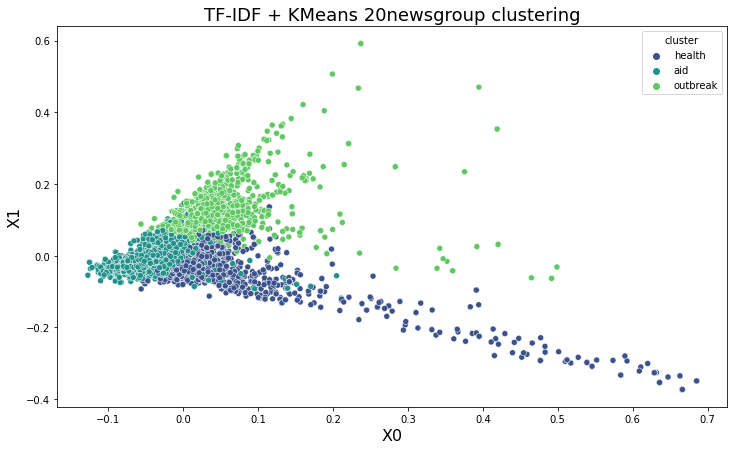

In [ ]:
# viz libs
import matplotlib.pyplot as plt
import seaborn as sns

# set image size
plt.figure(figsize=(12, 7))
# set a title
plt.title("TF-IDF + KMeans 20newsgroup clustering", fontdict={"fontsize": 18})
# set axes names
plt.xlabel("X0", fontdict={"fontsize": 16})
plt.ylabel("X1", fontdict={"fontsize": 16})
# create scatter plot with seaborn, where hue is the class used to group the data
sns.scatterplot(data=coaid, x='x0', y='x1', hue='cluster', palette="viridis")
plt.show()

Clustering technique worked well, we found 3 distinct groups 

Our goal of the clustering was to find groups of similar instances. Let's now calculate the similarity metrics for each group and take the average. This should give a more accurate similarity metric.

In [ ]:
coaid.head()

,text,hashtags,newstext,label,cluster,x0,x1
73487,today topic covid staying together invite ever...,EUPHW mentalhealth HomenautTools,americans reporting significant sustained incr...,0,health,0.051419,0.070104
99035,compiled resources guidelines get tested covid...,,order get keep america open states tribes loca...,0,health,0.009571,-0.044485
90274,contact tracing work,,,0,aid,-0.064044,-0.043317
3414,trial drug significantly block early stages co...,,,0,aid,-0.046787,-0.032620
107221,communities protected fired citizens williamsb...,,learn telehealth technology help safely provid...,0,health,0.395086,-0.224722


In [ ]:
health = coaid.loc[coaid['cluster'] == 'health']
aid = coaid.loc[coaid['cluster'] == 'aid']
outbreak = coaid.loc[coaid['cluster'] == 'outbreak']

In [ ]:
outbreak.head()

,text,hashtags,newstext,label,cluster,x0,x1
80945,mosquito tick populations unchecked amid covid,,,0,outbreak,0.014692,0.108680
4972,median incubation period covid days symptoms a...,,,0,outbreak,0.044574,0.098254
7723,full influenza vaccination among children cuts...,,,0,outbreak,0.022695,0.101412
50878,world water development report water climate c...,adaptation mitigation,actions persons communities take help slow tra...,0,outbreak,0.070777,0.149973
12429,tyler say flu isnt contagious agree speed covi...,,flu contagious people catch flu transmit virus...,0,outbreak,0.073659,0.235327


Now we'll calculate the jaccard similarity for every subdataframe and take overall average 

In [ ]:
def get_jaccard_sim(str1, str2):
   a = set(str1.split())
   b = set(str2.split())
   c = a.intersection(b)
   return float(len(c)) / (len(a) + len(b) - len(c))

In [ ]:
#health average similarity via Jaccard 
total_1 = 0 
teller_1 = 0
for i in range(len(health['text'])): 
    if i%100 == 0: 
        print(i)
    for j in range(i+1,len(health['text'])):
        total_1 = total_1 + get_jaccard_sim(health.iloc[i,0],health.iloc[j,0])
        teller_1 = teller_1 + 1 

avg_sim_1 = total_1/teller_1

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600


In [ ]:
avg_sim_1

0.015647917531335858

In [ ]:
#aid average similarity via Jaccard 
total_2 = 0 
teller_2 = 0
for i in range(len(aid['text'])): 
    if i%100 == 0: 
        print(i)
    for j in range(i+1,len(aid['text'])):
        total_2 = total_2 + get_jaccard_sim(aid.iloc[i,0],aid.iloc[j,0])
        teller_2 = teller_2 + 1 

avg_sim_2 = total_2/teller_2

avg_sim_2

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700


0.014975728807056015

In [ ]:
#outbreak average similarity via Jaccard 
total_3 = 0 
teller_3 = 0
for i in range(len(outbreak['text'])): 
    if i%100 == 0: 
        print(i)
    for j in range(i+1,len(outbreak['text'])):
        total_3 = total_3 + get_jaccard_sim(outbreak.iloc[i,0],outbreak.iloc[j,0])
        teller_3 = teller_3 + 1 

avg_sim_3 = total_3/teller_3

avg_sim_3

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600


0.015568782031935997

In [ ]:
(avg_sim_1+avg_sim_2+avg_sim_3)/3

0.015397476123442624

As this avg similarity doesn't really differ from the average jaccard similarity calculated over the entire coaid dataset, we'll search for the elbow point and then redo the full procedure. 

First we'll define a function to calc avg_sim 

In [ ]:
def calc_avg_sim(data): 
    total = 0 
    teller = 0
    for i in range(len(data['text'])): 
        if i%100 == 0: 
            print(i)
        for j in range(i+1,len(data['text'])):
            total = total + get_jaccard_sim(data.iloc[i,0],data.iloc[j,0])
            teller = teller + 1 

    avg_sim = total/teller

    return avg_sim

Then code for finding the optimal K

In [ ]:
def cluster_text(text):
    vectorizer = TfidfVectorizer(stop_words={'english'})
    X = vectorizer.fit_transform(text)

    import matplotlib.pyplot as plt
    from sklearn.cluster import KMeans
    Sum_of_squared_distances = []
    K = range(2,10)
    for k in K:
       km = KMeans(n_clusters=k, max_iter=200, n_init=10)
       km = km.fit(X)
       Sum_of_squared_distances.append(km.inertia_)
    plt.plot(K, Sum_of_squared_distances, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Sum_of_squared_distances')
    plt.title('Elbow Method For Optimal k')
    plt.show()

    print('How many clusters do you want to use?')
    true_k = int(input())
    model = KMeans(n_clusters=true_k, init='k-means++', max_iter=200, n_init=10)
    model.fit(X)

    labels=model.labels_
    clusters=pd.DataFrame(list(zip(text,labels)),columns=['title','cluster'])
    #print(clusters.sort_values(by=['cluster']))

    for i in range(true_k):
        print(clusters[clusters['cluster'] == i])
        
    return clusters

In [ ]:
txt = coaid['text']

In [ ]:
txt_list = list(txt)

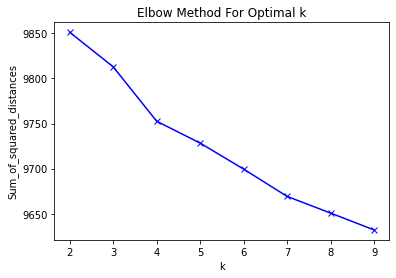

How many clusters do you want to use?


 7


                                                  title  cluster
0                   pandemic silver lining better sleep        0
3     stay safe home disinfecting surfaces wiping ha...        0
7           sports country reopening safe play softball        0
8     vereine gap testing capacity actual tests incr...        0
10    watching people grappling science viii increas...        0
...                                                 ...      ...
9987  n t miss summer money camp welcome take advant...        0
9988  mark calendars may global day giving emergency...        0
9989  unbelievable increases deaths week the ttc ret...        0
9990  nyc loose k every year flu coronavirus way con...        0
9993  re serious fixing racial disparities need thin...        0

[5370 rows x 2 columns]
                                                  title  cluster
5     nih clinical trial shows remdesivir accelerate...        1
153    nih clinical trial remdesivir treat covid begins        1


In [ ]:
clusters = cluster_text(txt_list)

In [ ]:
clusters = clusters.rename(columns={"title": "text"})
clusters

,text,cluster
0,pandemic silver lining better sleep,0
1,antiviral remdesivir prevents disease progress...,4
2,uk local authorities ready number deaths covid,4
3,stay safe home disinfecting surfaces wiping ha...,0
4,said covid testing dont test dont cases stoppe...,4
...,...,...
9995,united nations human settlements programme un ...,2
9996,contagious likely know youre sick,3
9997,covid could seasonal face warns coronavirus li...,4
9998,nih clinical trial investigations vaccine covi...,1


In [ ]:
df0 = clusters.loc[clusters['cluster'] == 0]
df1 = clusters.loc[clusters['cluster'] == 1]
df2 = clusters.loc[clusters['cluster'] == 2]
df3 = clusters.loc[clusters['cluster'] == 3]
df4 = clusters.loc[clusters['cluster'] == 4]
df5 = clusters.loc[clusters['cluster'] == 5]
df6 = clusters.loc[clusters['cluster'] == 6]


In [ ]:
total = (calc_avg_sim(df0)+calc_avg_sim(df1)+calc_avg_sim(df2)+calc_avg_sim(df3)+calc_avg_sim(df4)+calc_avg_sim(df5)+calc_avg_sim(df6))/7


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
0
100
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
0
100
200
300
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
0
100
200
300
0


In [ ]:
total

0.16763779075496307

In [ ]:
print(len(df0))
print(len(df1))
print(len(df2))
print(len(df3))
print(len(df4))
print(len(df5))
print(len(df6))


5370
176
1280
301
2447
360
66
